### Benz Car Detection With Detectron2

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
# 일반적인 라이브러리 임포트
import numpy as np
import pandas as pd
import os, json, cv2, random
from os.path import join
from glob import glob
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches

# import some common detectron2 utilities
# 일반적인 detectron 유틸리티 임포트
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# imshow function (cv2 image -> plt image -> plt.show)
# cv2 image를 plt image로 출력 
def imshow(in_img):
    out_img = cv2.cvtColor(in_img,cv2.COLOR_BGR2RGB) 
    plt.imshow(out_img)
    plt.axis('off')
    plt.show()

#### vott csv (category=1) -> dataset/annotation/*.txt

In [3]:
# csv 파일 읽어서 ndarrray로 저장 (image,xmin,ymin,xmax,ymax)
x=pd.read_csv('dataset/sha_car_project-export.csv',usecols=['image','xmin','ymin','xmax','ymax']).values
# ndarray를 'image'의 숫자를 기준으로 정렬
    
# ndarray의 'image'를 숫자로 변경 
for i,name in enumerate(x[:,0]):
    name=str(name).split('_')[1]
    num=int(name.split('.')[0])
    x[i][0]=num

# 데이터 프레임으로 변경 후 정렬
x_df=pd.DataFrame(x) 
x_df.columns=['num','xmin','ymin','xmax','ymax']
x_df=x_df.sort_values(by=['num'],axis=0)

# 다시 ndarray로 변경
x=x_df.to_numpy()

In [4]:
# 디렉토리 생성
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

dir_name='annotation'
dir_path='./dataset/'+dir_name
createFolder(dir_path)

In [5]:
# 어노테이션 파일들 생성 
# (주의) 두 번 이상 실행 시 기존 어노테이션 파일은 삭제 후 진행할 것!!
for x_one in x:
    path=dir_path+'/annotation_text_'+str(x_one[0])+'.txt'
    print(path,end=' -> ')
    with open(path,'a') as f:
        for idx2,val in enumerate(x_one):
            # 'num'은 파일 내용에서 제외 
            if idx2 != 0:
                # 마지막 원소(ymax)가 아닐 때
                if idx2 != len(x_one)-1:
                    f.write(str(val)+',')
                    print(val,end=',')
                # 마지막 원소(ymax)일 때
                else:
                    f.write(str(val)+'\n')
                    print(val,end='\n')

./dataset/annotation/annotation_text_0.txt -> 46.98277050310131,41.235613567073166,240.06547208821505,133.77341844512193
./dataset/annotation/annotation_text_1.txt -> 24.807702654232425,38.22402597402598,250.51788916786228,140.02272727272728
./dataset/annotation/annotation_text_2.txt -> 29.4972341954023,10.840909090909095,234.264367816092,167.31818181818184
./dataset/annotation/annotation_text_3.txt -> 44.24534803583735,26.50830258302583,263.40454858718124,141.54981549815497
./dataset/annotation/annotation_text_4.txt -> 59.94279832613391,50.701298701298704,220.11198479121668,137.6461038961039
./dataset/annotation/annotation_text_5.txt -> 39.28325292901447,26.92158671586716,296.07167470709857,163.30535055350555
./dataset/annotation/annotation_text_6.txt -> 17.420583468395456,40.521645021645,254.65469256482976,177.83333333333331
./dataset/annotation/annotation_text_7.txt -> 49.84560610151188,46.74025974025975,228.67170626349892,150.3214285714286
./dataset/annotation/annotation_text_8.txt

##### Check Bounding Box

In [4]:
# (이미지, 어노테이션) 파일명을 리스트로 저장
# (주의) 이미지 파일명에 '_'는 반드시 한 개만 들어가야 됨 
image_list = glob("dataset/image/*.jpg")
label_list = glob("dataset/annotation/*.txt")

# 파일명으로부터 Topic 찾기
topic=(image_list[0]).split('_')[0]
topic=topic[14:]

# 리스트 재생성 (len(imag_list)만큼)
for i,image in enumerate(image_list):
    image_list[i]=image[:14]+topic+'_'+str(i)+image[-4:]

# 리스트 재생성 (len(label_list)만큼)
for i,label in enumerate(label_list):
    label_list[i]=label[:35]+str(i)+label[-4:]

print(len(image_list),len(label_list))

100 100


In [5]:
test_image = image_list[0]
test_label = label_list[0]
print(test_image,test_label)

dataset/image/benz%20car_0.jpg dataset/annotation/annotation_text_0.txt


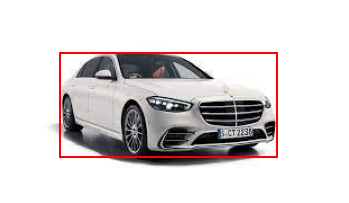

In [6]:
# bounding box check
image = plt.imread(test_image)
with open(test_label) as label:
    while True:
        item = label.readline()
        if item is None or len(item)<=0:
            break
        item = item.split(',')
        xmin = float(item[0])
        ymin = float(item[1])
        xmax = float(item[2])
        ymax = float(item[3])
        width = xmax - xmin
        height = ymax - ymin
        ax = plt.gca()
        plt.imshow(image)
        rect = patches.Rectangle(
                (xmin, ymin), width, height, linewidth=2, edgecolor='red', fill=False
            )
        ax.add_patch(rect)
        plt.axis('off')


##### annotation/*.txt and image/*.jpg -> COCO JSON

In [7]:
# coco json으로 만들기 위한 label 파싱 (id,image_id,category_id,bbox)
def parse_label(label_path, id, _annot_id):
    annot_id = _annot_id
    list_annot = []

    with open(label_path) as fobj:
        while True:
            item = fobj.readline()
            if item is None or len(item) <= 0: break

            item = item.split(',')

            class_ = 0

            xmin = float(item[0])
            ymin = float(item[1])
            xmax = float(item[2])
            ymax = float(item[3])
            width = float(xmax - xmin)
            height = float(ymax - ymin)
            
            annotation = dict()
            annotation["id"] = int(annot_id) # 각 오브젝트에 대한 아이디
            annotation["image_id"] = int(id) # 영상 아이디
            annotation["category_id"] = int(class_)
            annotation["bbox"] = [xmin, ymin, width, height]
            annotation["iscrowd"]=0 # 여러 개이거나 뭉쳐 있는 경우 1, 그런 데이터 거의 없으니 일단 0으로 통일 
            annotation["area"]=100.0 # segmentation mask에서 픽셀의 수, segmentatoin에서 쓰이지만 detection에서 안 쓰면 evaluate error가 발생하므로 그냥 추가했음 
            list_annot.append(annotation)
            annot_id += 1
            
    # 파싱한 것(딕셔너리), 개수 반환
    return list_annot, annot_id

In [8]:
# coco json으로 만들기 위한 영상 파싱 (id,width,height,file_name)
def parse_image(image_path, id):
    _image = Image.open(image_path)
    width, height = _image.size
    file_name = os.path.basename(image_path)
    
    image = dict()
    image["id"] = id
    image["width"] = int(width)
    image["height"] = int(height)
    image["file_name"] = file_name
    _image.close()

    # 파싱한 것(딕셔너리) 반환
    return image

In [9]:
# 카테고리 정보 생성
categories = [
        {
        "id" : 0,
        "name" : "car"
    }
]

print(categories)

[{'id': 0, 'name': 'car'}]


In [10]:
# 학습 데이터에 대한 coco json 만들기

# 파싱한 것 가져오기
images = []
annotations = []
annot_id = 0
for id, image_path in tqdm(enumerate(image_list[:-10])): # tqdm: 진행률 프로그레스 바
    label_path = join("dataset/annotation", "annotation_text_"+str(id) + ".txt")
     # 이미지 파싱한 것 저장
    images.append(parse_image(image_path, id))
    # 라벨 파싱한 것 저장
    parsed_annotations, annot_id = parse_label(label_path, id, annot_id)
    for annotation in parsed_annotations:
        annotations.append(annotation)

# labels_train.json 생성
coco_format = dict()
coco_format["info"] = "benz-car train dataset"
coco_format["images"] = images
coco_format["annotations"] = annotations
coco_format["licenses"] = "..."
coco_format["categories"] = categories
with open("dataset/labels_train.json", "w") as f:
    json.dump(coco_format, f)

90it [00:00, 10957.86it/s]


In [11]:
# 테스트 데이터에 대한 coco json 만들기

# 파싱한 것 가져오기
images = []
annotations = []
annot_id = 0
for id, image_path in tqdm(enumerate(image_list[-10:])): # tqdm: 진행률 프로그레스 바
    label_path = join("dataset/annotation", "annotation_text_"+str(id) + ".txt")
     # 이미지 파싱한 것 저장
    images.append(parse_image(image_path, id))
    # 라벨 파싱한 것 저장
    parsed_annotations, annot_id = parse_label(label_path, id, annot_id)
    for annotation in parsed_annotations:
        annotations.append(annotation)

# labels_test.json 생성
coco_format = dict()
coco_format["info"] = "benz-car test dataset"
coco_format["images"] = images
coco_format["annotations"] = annotations
coco_format["licenses"] = "..."
coco_format["categories"] = categories
with open("dataset/labels_test.json", "w") as f:
    json.dump(coco_format, f)

10it [00:00, 8509.44it/s]


In [12]:
# coco format dataset을 등록
from detectron2.data.datasets import register_coco_instances

# 입력 파라메터 설명: ("데이터셋 이름", "메타데이터", "json 경로", "이미지들의 경로"
register_coco_instances("benz_car_train", {}, "dataset/labels_train.json", "dataset/train_image")
register_coco_instances("benz_car_test", {}, "dataset/labels_test.json", "dataset/test_image")

##### Train & Inference & Evaluate

In [13]:
# config 객체를 선언하고 불러옵니다.
cfg = get_cfg()
# Detectron2에서 사전 정의한 faster_rcnn config 파일을 불러옵니다.
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
# 학습 데이터셋, 테스트 데이터셋
cfg.DATASETS.TRAIN = ("benz_car_train",)
cfg.DATASETS.TEST = ("benz_car_test",)
# 데이터를 불러오는 loader의 수를 정합니다. 일반적으로 'cpu 코어의 수 / 2'만큼 설정합니다. 큰 영향은 끼치지 않는 것 같습니다.
cfg.DATALOADER.NUM_WORKERS = 4
# pretrained checkpoint를 불러옵니다.
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")
# batch size입니다.
cfg.SOLVER.IMS_PER_BATCH = 2
# 학습 수행 시의 iteration 횟수입니다.
cfg.SOLVER.MAX_ITER = 2000
# checkpoint를 저장하는 iteration 간격을 설정합니다.
cfg.SOLVER.CHECKPOINT_PERIOD = 50
# base learning rate를 설정합니다.
cfg.SOLVER.BASE_LR = 0.001  
# WarmupMultiStepLR의 step을 설정합니다. 적용하지 않기를 원하기 때문에 빈 list를 넣었습니다.
cfg.SOLVER.STEPS = []  # do not decay learning rate
# faster_rcnn config이 추론할 class의 수를 설정합니다.
cfg.MODEL.RETINANET.NUM_CLASSES = 1

In [14]:
#학습된 모델의 가중치 파일을 저장할 폴더 생성 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# config 파일을 토대로 trainer를 불러옵니다.
trainer = DefaultTrainer(cfg)
# 가장 최근의 checkpoint를 불러오거나(resume=True인 경우) config 파일의 weights 링크로부터 weights를 불러옵니다.
trainer.resume_or_load(cfg)
# 학습을 진행합니다.
trainer.train()

[12/31 03:32:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [ ]:
# 시각화된 학습 곡선 및 기타 값들을 텐서보드를 통해 확인 가능 
%load_ext tensorboard
%tensorboard --logdir output

In [16]:
#학습된 모델의 가중치 파일을 불러오기 
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
#모델이 클래스에 대해 예측한 확률이 몇 threshold 이상이어야 결과로 출력할지 설정
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
#DefaultPredictor 생성 
predictor = DefaultPredictor(cfg)

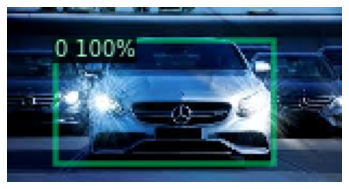

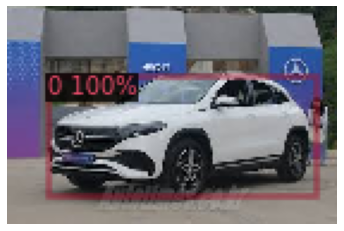

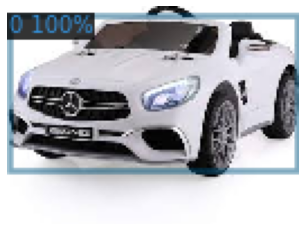

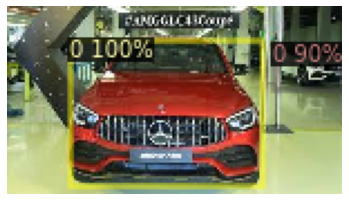

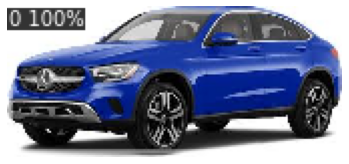

In [17]:
# 인퍼런스
for image_path in random.sample(image_list[-10:],5):
    im = cv2.imread(image_path)
    outputs = predictor(im)  
    #Visualizer 생성 
    v = Visualizer(im[:, :, ::-1], scale=0.5)
    #이미지 상에 예측한 결과들을 인스턴스(물체)별로 그리기 
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #이미지 화면에 출력 
    imshow(out.get_image()[:, :, ::-1])

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

#COCOEvaluator : 여러 task들에 대해 AP(Average Precision)을 측정할 수 있음 
#데이터셋 이름, 측정할 task 종류들, False(현재 과정의 결과들만을 측정), dataset에서 예측된 모든 결과들을 저장할 경로)
evaluator = COCOEvaluator("benz_car_test", ("bbox",), False, output_dir="./output/")
#테스트 셋으로 구성된 test loader 생성 
val_loader = build_detection_test_loader(cfg, "benz_car_test")
#테스트 셋으로 모델 성능 측정 
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [12/31 03:32:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/31 03:32:57 d2.data.datasets.coco]: Loaded 10 images in COCO format from dataset/labels_test.json
[12/31 03:32:57 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/31 03:32:57 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[12/31 03:32:57 d2.data.common]: Serialized dataset takes 0.00 MiB
[12/31 03:32:57 d2.evaluation.evaluator]: Start inference on 10 batches
[12/31 03:32:58 d2.evaluation.evaluator]: Total inference time: 0:00:00.509835 (0.101967 s / iter per device, on 1 devices)
[12/31 03:32:58 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.094264 s / iter per device, on 1 devices)
[12/31 03:32:58 d2.evaluation.coco_evaluation]: Preparing results for COCO format ..

In [13]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}